<div style="background: navy; color: white; padding: 20px">

# $\S 7$: Market Regime Detection with Rough Path Signatures: Real-data examples

In this notebook, we step through the examples shown in Section 8 of the paper "Non-parametric online market regime detection and regime clustering for multidimensional and path-dependent data structures".

Here, we apply our techniques to real data and study the results. We provide three experiments here: 
1) A standard on-line detection run with the Auto-Evaluator on a basket of equities,
2) A standard online detection run with the Auto-Evaluator on a basket of cryptocurrencies, and
3) A fully data-driven approach to online market regime detection by classifying regimes using the chosen MMD metric and instantiating our future beliefs with the clusters obtained from the classifier.

In [1]:
import sys
import os
from pathlib import Path

notebook_dir = Path.cwd()

project_root = notebook_dir.parent

sys.path.append(str(project_root))

from src.generators.Model import Model

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import yfinance as yf
#from fastquant import get_crypto_data
from sklearn.cluster import AgglomerativeClustering
from tqdm import tqdm

from src.testing import TestConfig
from src.testing.discriminators import AutoEvaluator, GeneralMMDDetector
from src.testing.discriminators.config import ProcessorConfig
from src.testing.experiment_functions.plot_result_functions import plot_path_test_threshold
from src.utils.Config import Config
from src.utils.auxiliary_classes.PathTransformer import PathTransformer, PathTransformerConfig
from src.utils.helper_functions.data_helper_functions import ema
from src.utils.helper_functions.global_helper_functions import get_project_root
from src.utils.helper_functions.plot_helper_functions import make_grid, golden_dimensions
from src.utils.helper_functions.test_helper_functions import get_memberships, get_sub_paths, get_grouped_paths, \
    get_alphas

<div style="background: navy; color: white; padding: 20px">

## $\S 7.1$: Real data Auto-Evaluator, equity data

We begin by extracting equity data using the <code>yfinance</code> package.

In [3]:
yf_interval = "1d"

symbols = ["^GSPC", "KO", "IBM", "PG", "JPM", "XOM", "GE"]

In [4]:
start_date = "1980-01-01"
end_date   = "2021-12-31"

data       = yf.download(" ".join([s for s in symbols]), start=start_date, end=end_date, interval=yf_interval)
vix_data   = yf.download("VXX", start="2005-01-01", end="2021-12-01")["Close"]
data_clean = data.dropna()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  7 of 7 completed
[*********************100%***********************]  1 of 1 completed


In [5]:
data_clean = data_clean[["Close"]]
np_data = data_clean.copy().to_numpy()

In [6]:
tickers = data_clean[["Close"]]["Close"].columns.values

In [7]:
cluster_path_real        = np.zeros((data_clean.shape[0], data_clean.shape[1] + 1))
cluster_path_real[:, 1:] = np_data
cluster_path_real[:, 0]  = data_clean.index.to_numpy()

snp_plot                 = np.zeros((data_clean.shape[0], 2))
snp_plot[:, 0]           = data_clean.index.to_numpy()
snp_plot[:, 1]           = np_data[:, -1]

In [17]:
data_clean

Price           Close                                                 \
Ticker             GE         IBM         JPM         KO          PG   
Date                                                                   
1980-03-17   1.377966    3.949465    1.053012   0.170909    0.550272   
1980-03-18   1.396387    3.982867    1.060755   0.174561    0.557914   
1980-03-19   1.370597    3.932769    1.076241   0.173100    0.564465   
1980-03-20   1.348491    3.891017    1.068498   0.171639    0.564465   
1980-03-21   1.363228    3.790819    1.091726   0.170909    0.565557   
...               ...         ...         ...        ...         ...   
2021-12-23  57.648705  113.674812  142.959564  52.803314  146.837006   
2021-12-27  58.028954  114.536285  143.777740  53.193306  148.552063   
2021-12-28  58.445988  115.415207  144.214050  53.401917  149.350021   
2021-12-29  58.133209  116.041763  144.141373  53.465401  150.588165   
2021-12-30  58.078022  116.529060  144.068619  53.311218  149.285797   

Price                               
Ticker            XOM        ^GSPC  
Date                                
1980-03-17   0.538121   102.260002  
1980-03-18   0.550961   104.099998  
1980-03-19   0.549794   104.309998  
1980-03-20   0.540455   103.120003  
1980-03-21   0.546291   102.309998  
...               ...          ...  
2021-12-23  54.395348  4725.790039  
2021-12-27  55.170895  4791.189941  
2021-12-28  54.992603  4786.350098  
2021-12-29  54.511230  4793.060059  
2021-12-30  54.190311  4778.729980  

[10539 rows x 7 columns]

In [ ]:
np_data[:,-1] #S&P 500 data

array([ 102.26000214,  104.09999847,  104.30999756, ..., 4786.35009766,
       4793.06005859, 4778.72998047])

In [14]:
data_clean.index.to_numpy()

array(['1980-03-17T00:00:00.000000000', '1980-03-18T00:00:00.000000000',
       '1980-03-19T00:00:00.000000000', ...,
       '2021-12-28T00:00:00.000000000', '2021-12-29T00:00:00.000000000',
       '2021-12-30T00:00:00.000000000'], dtype='datetime64[ns]')

<div style="background: navy; color: white; padding: 20px">

## 1. Configuration

In [ ]:
path_transformer_config = PathTransformerConfig()

dt = 1/252  # Approximately

path_transformer_config.set_transformations({
    "standardise_path_transform":    (True,  0, {"s_type": "initial"}),
    "time_difference_transform":     (False, 0, {}),
    "time_normalisation_transform":  (True,  0, {}),
    "difference_transform":          (False, 0, {}),
    "translation_transform":         (False, 0, {}), 
    "scaling_transform":             (False, 0, {"sigmas": [dt**-0.5 for _ in range(len(tickers))]}),
    "cumulant_transform":            (False, 2, {}),
    "increment_transform":           (False, 2, {}),
    "lead_lag_transform":            (False, 3, {}),
    "invisibility_transform":        (False, 4, {}),
})
cl
offset  = 0
n_steps = 8
n_paths = 8

real_test_config = TestConfig()
real_test_config.n_steps = n_steps
real_test_config.n_paths = n_paths
real_test_config.offset  = offset

n_steps_real = real_test_config.n_steps
n_paths_real = real_test_config.n_paths

pt          = PathTransformer(path_transformer_config)
sp_real     = get_sub_paths(cluster_path_real, n_steps, offset)
snp_sp_real = get_sub_paths(snp_plot, n_steps, offset)
mmd_real    = get_grouped_paths(sp_real, n_paths)
sp_t_real   = pt.transform_paths(sp_real.copy())
mmd_t_real  = get_grouped_paths(sp_t_real, n_paths)

100%|██████████| 1317/1317 [00:00<00:00, 52423.33it/s]


<div style="background: navy; color: white; padding: 20px">

## 2. Instantiate Auto Evaluator

In [19]:
processor_config = ProcessorConfig()

processor_config.override_args({
   "autoevaluator_kwargs": Config(**{
        "metric_kwargs": Config(**{
            "kernel_type": "rbf",
            "metric_type": "mmd",
            "sigmas": [1],
            "dyadic_orders": [2],
            "lambd": 1
        }),
        "n_scores": 200,
        "evaluator_kwargs": Config(**{
            "lags" : [-4, -8, -12],
            "threshold_method": "bootstrap",
        })
    })
})

processor_config.alpha_value = 0.95

auto_evaluator = AutoEvaluator(
    path_transformer = pt,
    processor_config = processor_config,
    test_config      = real_test_config
)

Metric initialized. MMD1, kernel = rbf, dyadic_order = 2


<div style="background: navy; color: white; padding: 20px">

## 3. Calculate scores

In [20]:
real_data_scores = auto_evaluator.evaluate_path(cluster_path_real)

real_indexes_ = real_data_scores[0, :]
real_scores_  = real_data_scores[1, :]
real_alphas_  = real_data_scores[2, :]

  0%|          | 0/1298 [00:00<?, ?it/s]d:\ETH & UZH\ETH\Machine Learning in Finance and Complex System\MLFCS\lib\site-packages\numba\cuda\dispatcher.py:536: NumbaPerformanceWarning: Grid size 64 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
100%|██████████| 1298/1298 [00:26<00:00, 49.03it/s]


<div style="background: navy; color: white; padding: 20px">

## 4. Plot results

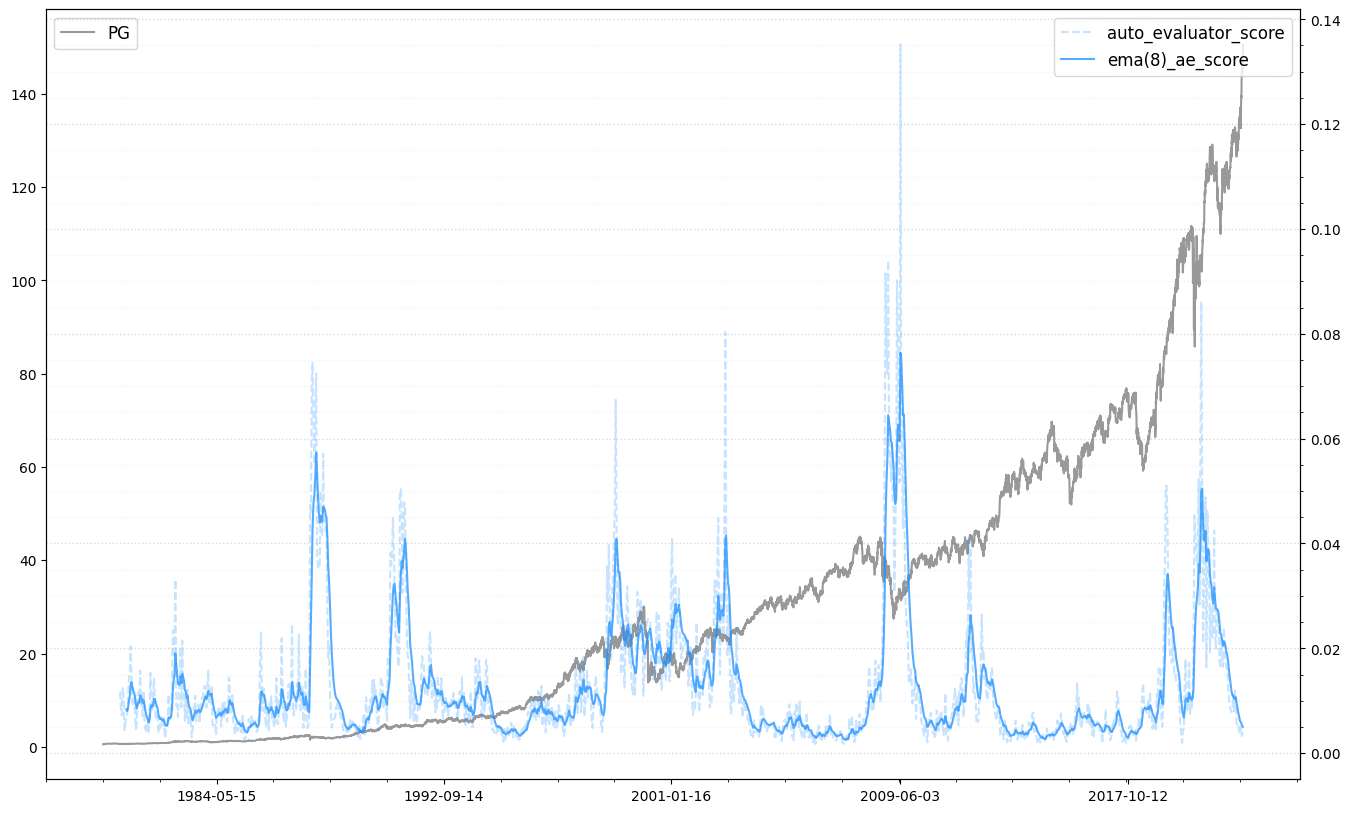

In [21]:
matplotlib.rc_file_defaults()

width = 10
price_indexes  = cluster_path_real[:, 0]
score_indexes  = real_indexes_
to = int(0.10*price_indexes.shape[0])

ind = 5

k = real_test_config.n_paths

plt.figure(figsize=golden_dimensions(width))
ax = plt.gca()

ax.plot(price_indexes, cluster_path_real[:, ind], color='black', alpha=0.4, label=tickers[ind-1])
ax2 = ax.twinx()
ax2.plot(score_indexes, real_scores_, color="dodgerblue", linestyle="dashed", alpha=0.25, label="auto_evaluator_score")
#ax2.plot(score_indexes, real_alphas_, color="tomato", alpha=0.25, label="crit_thresh")
ax2.plot(score_indexes[k-1:], ema(real_scores_, k), color="dodgerblue", alpha=0.75, label="ema({})_ae_score".format(k))
make_grid()
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), prop={'size': 12}, loc="upper left")
ax2.legend(loc="upper right", prop={'size': 12});
plt.xticks(price_indexes[to::2*to], list(map(lambda x: pd.Timestamp(x).strftime('%Y-%m-%d'), price_indexes[to::2*to])))
plt.show();

In [ ]:
lags         = processor_config.autoevaluator_kwargs.evaluator_kwargs.lags
one_dim      = True
sub_paths    = snp_sp_real
alphas       = np.hstack([[0. for _ in range(len(lags) + n_paths - 1)], real_scores_ > real_alphas_])
as_timestamp = True
save_image   = [False]

plt.figure(figsize=golden_dimensions(10))
dim = sub_paths.shape[-1] - 1
plot_dim = dim if not one_dim else 1

for di in range(plot_dim):
    fig, ax = plt.subplots(1, 1 + di, figsize=golden_dimensions(width))
    ax.set_xlabel("$t$")
    ax.set_ylabel("$S$")

    for p, alph in zip(sub_paths, alphas):
        if alph == 0.0:
            ax.plot(p[:, 0], p[:, 1 + di], color='dodgerblue', linestyle="dashed", alpha=0.05)
        else:
            ax.plot(p[:, 0], p[:, 1 + di], color='dodgerblue', alpha=alph)

    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), prop={'size': 12}, loc="upper left")
    make_grid()

    if as_timestamp:
        indexes = sub_paths[:, :, 0].flatten()
        to = int(0.10*indexes.shape[0])
        ax.set_xticks(indexes[to::2*to])
        ax.set_xticklabels(list(map(lambda x: pd.Timestamp(x).strftime('%Y-%m-%d'), indexes[to::2*to])))

if save_image[0]:
    plt.savefig(get_project_root().as_posix() + "/data/images/alpha_plots/{}.png".format(save_image[1]), dpi=300)

plt.show()

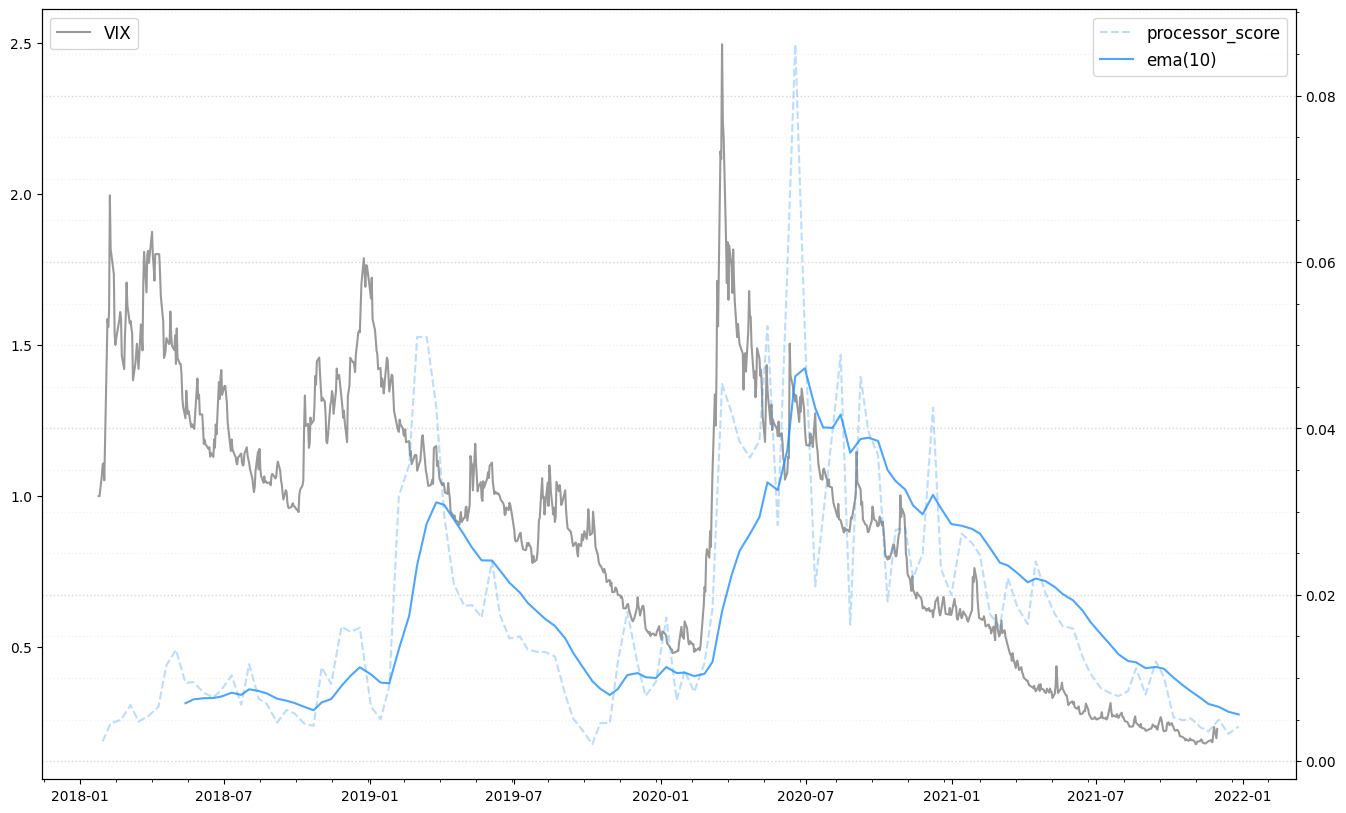

In [22]:
vix_indexes            = np.argwhere(np.array(list(map(lambda x: pd.Timestamp(x), score_indexes))) > vix_data.index[0]).T[0]
vix_index_values       = list(map(lambda x: pd.Timestamp(x), np.array(score_indexes)[vix_indexes]))
processor_vix_scores   = real_scores_[vix_indexes]

k = 10

plt.figure(figsize=golden_dimensions(width))
ax = plt.gca()
ax.plot(vix_data.index, vix_data.values/vix_data.values[0], color='grey', alpha=0.8, label="VIX")
ax2 = ax.twinx()
ax2.plot(vix_index_values, processor_vix_scores, color='dodgerblue', linestyle="dashed", alpha=0.3, label="processor_score")
ax2.plot(vix_index_values[k-1:], np.array(ema(processor_vix_scores, k)), color='dodgerblue', alpha=0.8, label="ema({})".format(k))
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), prop={'size': 12}, loc="upper left")
ax2.legend(loc="upper right", prop={'size': 12})
make_grid()

<div style="background: navy; color: white; padding: 20px">

## $\S 7.1$: Clustering real data (equities)

Given our chosen metric and collections of transformed ensemble paths, we can apply an AgglomerativeClustering algorithm over the matrix of pairwise MMD scores.

In [23]:
# Generate pairwise distance matrix D_ij = \mathcal{D}^r_\text{sig}(\boldsymbol{s}^i, \boldsymbol{s}^j)

num_paths              = mmd_t_real.shape[0]
res                    = np.zeros((num_paths, num_paths))
generate_pairwise_data = True

if generate_pairwise_data:
    for i in tqdm(range(num_paths)):
        path_i = mmd_t_real[i]
        for j in range(i, num_paths):
            path_j = mmd_t_real[j]
            score = auto_evaluator.metric(path_i, path_j)
            res[i, j] = score
            if i != j:
                res[j, i] = score
    np.save(get_project_root().as_posix() + "/data/real_data_pw_distances.npy", res, allow_pickle=True)
else:
    try:
        res = np.load(get_project_root().as_posix() + "/data/real_data_pw_distances.npy", allow_pickle=True)
    except FileNotFoundError:
        print("Pairwise data matrix has not been generated yet. Please generate pairwise distances first.")

100%|██████████| 1310/1310 [1:25:50<00:00,  3.93s/it]


In [25]:
n_clusters = 6

clusters_real = AgglomerativeClustering(
    n_clusters = n_clusters, 
    metric   = "precomputed", 
    linkage    = "complete"
).fit(res)

In [26]:
# Transform labels so the earlier clusters have fewer elements
from collections import Counter

def rank_unique_elements(lst):
    # Count the occurrences of each element
    counts = Counter(lst)

    # Sort the unique elements based on their counts in descending order
    ranked_elements = sorted(counts.items(), key=lambda x: x[1], reverse=True)

    # Extract the unique elements from the ranked list
    unique_elements = [item[0] for item in ranked_elements]

    return unique_elements

ranks = rank_unique_elements(clusters_real.labels_)
rank_dict = {r: i for i, r in enumerate(ranks)}
labels_real = [rank_dict[l] for l in clusters_real.labels_]

In [27]:
indexes_real = mmd_real[:, -1, -1, 0]
scores_real  = np.array(labels_real)
cluster_score_array_real = np.c_[indexes_real, scores_real]

In [28]:
# Get average membership for each sub-path
real_memberships      = get_memberships(mmd_real)
average_cluster_score = np.array([np.mean(scores_real[ind]) for ind in real_memberships])
average_indexes       = sp_real[:, -1, 0]

unique_scores = np.unique(average_cluster_score)
n_colors      = np.unique(average_cluster_score).shape[0]
cmap          = sns.diverging_palette(133, 20, l=60, n=n_colors, center="light")

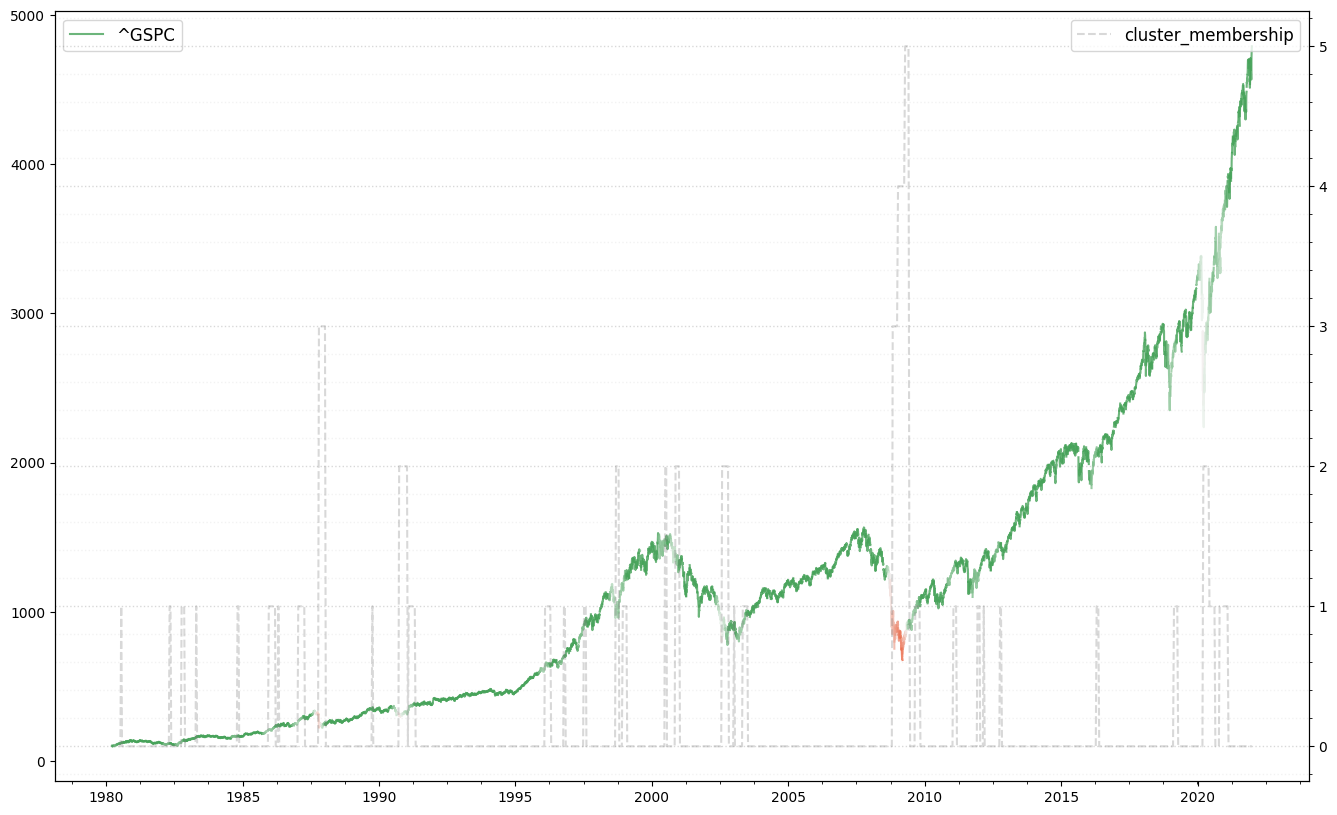

In [29]:
price_indexes   = [pd.Timestamp(x) for x in cluster_path_real[:, 0]]
score_indexes   = [pd.Timestamp(x) for x in indexes_real]
average_indexes = [pd.Timestamp(x) for x in average_indexes]
k=10

plt.figure(figsize=golden_dimensions(width))
ax = plt.gca()
for i, s in enumerate(sp_real):
    indexes = [pd.Timestamp(x) for x in s[:, 0]]
    color = cmap[int(np.argwhere(average_cluster_score[i] == unique_scores)[0][0])]
    ax.plot(indexes, s[:, -1], color=color, alpha=0.8, label="^GSPC")
ax2 = ax.twinx()
ax2.plot(score_indexes, scores_real, color='grey', alpha=0.3, label="cluster_membership", linestyle='dashed')
make_grid()
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), prop={'size': 12}, loc="upper left")
ax2.legend(loc="upper right", prop={'size': 12});

<div style="background: navy; color: white; padding: 20px">

## $\S7.2$: Basket of cryptocurrency pairs.

Here, we perform the same analysis with cryptocurrency data.

In [ ]:
# Get crypto data
start_date = "2019-06-01"
end_date = "2022-12-01"
pairs = ["BTC/USDT", "ADA/USDT", "ETH/USDT", "XRP/USDT", "BNB/USDT", "MATIC/USDT"]
crypto_prices = []

for pair in pairs:
    crypto = get_crypto_data(pair, start_date, end_date, time_resolution="1h")
    crypto_prices.append(crypto.close.values)
    print("Downloaded {}".format(pair))
    
index = crypto.index.values

In [ ]:
crypto_prices          = np.array(crypto_prices)
cluster_path_cy        = np.zeros((crypto_prices.shape[-1], len(pairs)+1))
cluster_path_cy[:, 0]  = index
cluster_path_cy[:, 1:] = crypto_prices.T

In [ ]:
# Break into sub-paths
n_steps_cy = 32
n_paths_cy = 8

path_transformer_config_cy = PathTransformerConfig()

path_transformer_config_cy.set_transformations({
    "standardise_path_transform":    (True,  0, {"s_type": "initial"}),
    "time_difference_transform":     (False, 0, {}),
    "time_normalisation_transform":  (True,  0, {}),
    "difference_transform":          (False, 0, {}),
    "translation_transform":         (True, 0, {}), 
    "scaling_transform":             (False, 0, {"sigmas": [2.5e1 for _ in range(len(pairs))]}),
    "cumulant_transform":            (False, 2, {}),
    "increment_transform":           (True, 2, {}),
    "lead_lag_transform":            (False, 3, {}),
    "invisibility_transform":        (False, 4, {}),
})

crypto_test_config = TestConfig()
crypto_test_config.n_steps = n_steps_cy
crypto_test_config.n_paths = n_paths_cy

pt_cy = PathTransformer(path_transformer_config_cy)
sp_cluster_cy    = get_sub_paths(cluster_path_cy, n_steps_cy, 0)
mmd_cluster_cy   = get_grouped_paths(sp_cluster_cy, n_paths_cy)
sp_cluster_t_cy  = pt_cy.transform_paths(sp_cluster_cy.copy())
mmd_cluster_t_cy = get_grouped_paths(sp_cluster_t_cy, n_paths_cy)

In [ ]:
processor_config_cy = ProcessorConfig()

processor_config_cy.autoevaluator_kwargs.override_args({
        "metric_kwargs": Config(**{
            "kernel_type": "rbf",
            "metric_type": "mmd",
            "sigmas": [1e0],
            "dyadic_orders": [3],
            "lambd": 5
        }),
        "evaluator_kwargs": Config(**{
            "lags": [-8, -16],
            "threshold_method": "bootstrap"
        }),
        "n_scores": 250
})

processor_config_cy.alpha_value = 0.95

auto_evaluator = AutoEvaluator(
    path_transformer = pt_cy, 
    processor_config = processor_config_cy,
    test_config      = crypto_test_config
)

In [ ]:
auto_cy = auto_evaluator.evaluate_path(cluster_path_cy)
auto_cy_indexes = auto_cy[0, :]
auto_cy_scores  = auto_cy[1, :]
auto_cy_alphas  = auto_cy[2, :]

In [ ]:
width = 10
price_indexes  = cluster_path_cy[:, 0]
score_indexes  = auto_cy_indexes
to = int(0.10*price_indexes.shape[0])

k = 16

plt.figure(figsize=golden_dimensions(width))
ax = plt.gca()

ax.plot(price_indexes, cluster_path_cy[:, 1], color='black', alpha=0.4, label="BTC/USDT")
ax2 = ax.twinx()
ax2.plot(score_indexes, auto_cy_scores, color="dodgerblue", linestyle="dashed", alpha=0.3, label="auto_mmd_score")
ax2.plot(score_indexes[k-1:], ema(auto_cy_scores, k), color="dodgerblue", alpha=0.8, label="ema({})_auto".format(k))
plt.grid(b=True, color='grey', linestyle=':', linewidth=1.0, alpha=0.3)
plt.minorticks_on()
plt.grid(b=True, which='minor', color='grey', linestyle=':', linewidth=1.0, alpha=0.1)
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), prop={'size': 12}, loc="upper left")
ax2.legend(loc="upper right", prop={'size': 12});
plt.xticks(price_indexes[to::2*to], list(map(lambda x: pd.Timestamp(x).strftime('%Y-%m-%d'), price_indexes[to::2*to])))
plt.show();

In [ ]:
lags         = processor_config_cy.autoevaluator_kwargs.evaluator_kwargs.lags
one_dim      = True
path_splits  = [0.]
sub_paths    = sp_cluster_cy[:, :, :2]
alphas       = np.hstack([[0. for _ in range(len(lags) + n_paths_cy - 1)], auto_cy_scores > auto_cy_alphas])
as_timestamp = True
save_image   = [False]

plt.figure(figsize=golden_dimensions(10))
dim = sp_cluster_cy.shape[-1] - 1
plot_dim = dim if not one_dim else 1

splits = [[x, y] for x, y in zip(path_splits[::2], path_splits[1::2])]

for di in range(plot_dim):
    plt.subplot(plot_dim, 1, 1 + di)
    ax1 = plt.gca()
    ax1.set_xlabel("$t$")
    ax1.set_ylabel("$S$")

    for p, alph in zip(sp_cluster_cy, alphas):
        if alph == 0.0:
            plt.plot(p[:, 0], p[:, 1 + di], color='dodgerblue', linestyle="dashed", alpha=0.05)
        else:
            plt.plot(p[:, 0], p[:, 1 + di], color='dodgerblue', alpha=alph)

    for split in splits:
        plt.axvspan(split[0], split[1], color='tomato', alpha=0.2, label="regime_change")

    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), prop={'size': 12}, loc="upper left")
    plt.grid(b=True, color='grey', linestyle=':', linewidth=1.0, alpha=0.3)
    plt.minorticks_on()
    plt.grid(b=True, which='minor', color='grey', linestyle=':', linewidth=1.0, alpha=0.1)

    if as_timestamp:
        indexes = sub_paths[:, :, 0].flatten()
        to = int(0.10*indexes.shape[0])
        ax1.set_xticks(indexes[to::2*to])
        ax1.set_xticklabels(list(map(lambda x: pd.Timestamp(x).strftime('%Y-%m-%d'), indexes[to::2*to])))

if save_image[0]:
    plt.savefig(get_project_root().as_posix() + "/data/images/alpha_plots/{}.png".format(save_image[1]), dpi=300)

plt.show()

In [ ]:
num_paths              = mmd_cluster_t_cy.shape[0]
res                    = np.zeros((num_paths, num_paths))
generate_pairwise_data = True

if generate_pairwise_data:
    for i in tqdm(range(num_paths)):
        path_i = mmd_cluster_t_cy[i]
        for j in range(i, num_paths):
            path_j = mmd_cluster_t_cy[j]
            score = auto_evaluator.metric(path_i, path_j)
            res[i, j] = score
            if i != j:
                res[j, i] = score
    np.save(get_project_root().as_posix() + "/data/crypto_data_pw_distances.npy", res, allow_pickle=True)
else:
    res = np.load(get_project_root().as_posix() + "/data/crypto_data_pw_distances.npy", allow_pickle=True)

In [ ]:
n_clusters = 4

clusters_real = AgglomerativeClustering(
    n_clusters = n_clusters, 
    affinity   = "precomputed", 
    linkage    = "complete"
).fit(res)

ranks = rank_unique_elements(clusters_real.labels_)
rank_dict = {r: i for i, r in enumerate(ranks)}
labels_cy = [rank_dict[l] for l in clusters_real.labels_]

In [ ]:
indexes_cy = mmd_cluster_cy[:, -1, -1, 0]
scores_cy  = np.array(labels_cy)
cluster_score_array_cy = np.c_[indexes_cy, scores_cy]

In [ ]:
# Get average membership for each sub-path
real_memberships      = get_memberships(mmd_cluster_cy)
average_cluster_score_cy = np.array([np.mean(scores_cy[ind]) for ind in real_memberships])
average_indexes_cy       = sp_cluster_cy[:, -1, 0]

unique_scores = np.unique(average_cluster_score_cy)
n_colors      = np.unique(average_cluster_score_cy).shape[0]
cmap          = sns.diverging_palette(133, 20, l=60, n=n_colors, center="light")

In [ ]:
price_indexes      = [pd.Timestamp(x) for x in cluster_path_cy[:, 0]]
score_indexes_cy   = [pd.Timestamp(x) for x in indexes_cy]
average_indexes_cy = [pd.Timestamp(x) for x in average_indexes_cy]
k=10

plt.figure(figsize=golden_dimensions(width))
ax = plt.gca()
for i, s in enumerate(sp_cluster_cy):
    indexes = [pd.Timestamp(x) for x in s[:, 0]]
    color = cmap[int(np.argwhere(average_cluster_score_cy[i] == unique_scores)[0][0])]
    ax.plot(indexes, s[:, 1], color=color, alpha=0.8, label="BTC/USDT")
ax2 = ax.twinx()
ax2.plot(score_indexes_cy, scores_cy, color='grey', alpha=0.3, label="cluster_membership", linestyle='dashed')
make_grid()
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), prop={'size': 12}, loc="upper left")
ax2.legend(loc="upper right", prop={'size': 12});

<div style="background: navy; color: white; padding: 20px">

## $\S 7.3$: A data-driven detection pipeline

If desired, with this method one can perform online market regime detection in a purely data-driven way. The pipeline is as follows - 

1) For given hyperparameters $h$, time window $[a, b]$ and time-augmented price path $\hat{\mathsf{s}} \in \mathcal{T}([a, b]; \mathbb{R}^d)$, compute $\mathcal{EP}^\Phi_h(\hat{\mathsf{s}})$.
2) Compute the matrix $D_{ij} = \mathcal{D}_{\text{sig}}^r(\boldsymbol{s}^i, \boldsymbol{s}^j)$ for $\boldsymbol{s}^i, \boldsymbol{s}^j \in \mathcal{EP}^\Phi_h(\hat{\mathsf{s}})$. 
3) For a given $k\in \mathbb{N}$, assign clusters to each $\boldsymbol{s}^i \in \mathcal{EP}^\Phi_h(\hat{\mathsf{s}})$ according to the provided AgglomerativeClustering hyperparameters 
4) Calculate the average cluster label for each $s \in \mathcal{SP}_h(\hat{\mathsf{s}})$, $\overline k_{x_i} = \frac{1}{h_1}\sum_{j \in\{i, i+1, \dots, i+h_2-1\}}k_{\boldsymbol{s}^j}$. Then, $k_{\boldsymbol{s}^i} = \mathrm{round}(\overline k_{\boldsymbol{s}^i})$. 
5) Beliefs are then given by $\mathfrak{P} = (\mathfrak{P}_1, \dots, \mathfrak{P}_k)$ where $\mathfrak{P}_l = \{s \in \mathcal{SP}_h(\hat{\mathsf{s}}): k_s = l\}$. Calculate the prior distributions $\mathfrak{D} = (\mathfrak{D}_1,\dots,\mathfrak{D}_k)$ in the same way.
6) For a newly observed section of $S$ over $(b, T]$, perform standard regime detection as outlined in previous sections.

There is an embedded assumption here that the cluster lables correspond to some kind of ordering, between calmer and more chaotic market conditions. This must be verified first in order for this method to work.

In [ ]:
start_date = "1980-01-01"
end_date   = "2023-05-01"

test_data = yf.download(" ".join([s for s in symbols]), start=start_date, end=end_date, interval=yf_interval)

In [ ]:
test_data_clean = test_data.dropna()
test_data_clean = test_data_clean[["Close"]]
test_np_data    = test_data_clean.copy().to_numpy()

test_path_real        = np.zeros((test_data_clean.shape[0], test_data_clean.shape[1] + 1))
test_path_real[:, 1:] = test_np_data
test_path_real[:, 0]  = test_data_clean.index.to_numpy()

In [ ]:
n_belief_clusters    = 2

rounded_scores       = np.round(average_cluster_score) >= int(n_clusters/2)

real_test_config.n_paths = 64
real_beliefs        = np.array([sp_real[np.asarray(rounded_scores == i).nonzero()[0]] for i in range(n_belief_clusters)])
real_belief_details = [f"cluster_{i}" for i in range(n_clusters)]

processor_config.override_args({
    "generalmmddetector_kwargs": Config(**{
        "n_tests": 512,
        "n_evaluations": 1,
        "metric_kwargs": Config(**{
            "kernel_type": "linear",
            "metric_type": "scoring",
            "sigmas": [5e-1],  
            "dyadic_orders": [2],  
            "lambd": 1
        }),
        "evaluator_kwargs": Config(**{
            "pct_ignore": 0.1
        })
    })
})

real_detector = GeneralMMDDetector(
    beliefs          = real_beliefs, 
    path_details     = real_belief_details,
    path_transformer = pt,
    processor_config = processor_config,
    test_config      = real_test_config
)

In [ ]:
real_scores_array = real_detector.evaluate_path(test_path_real, evaluation="total")

In [ ]:
# Extract sub paths for score functions 
sub_paths = get_sub_paths(test_path_real, real_test_config.n_steps, real_test_config.offset)
c_alpha_g = real_detector.critical_value

# Get alpha scores for test thresholds
if processor_config.generalmmddetector_kwargs.metric_kwargs.metric_type == "mmd":
    _n_paths      = real_test_config.n_paths
    mmd_paths     = get_grouped_paths(sub_paths, _n_paths)
    memberships   = get_memberships(mmd_paths)
    mmd_alphas_g  = get_alphas(memberships, real_scores_array, c_alpha_g)
else:
    _n_paths      = 1
    memberships   = np.array([[i] for i in range(sub_paths.shape[0])])
    mmd_paths     = get_grouped_paths(sub_paths, _n_paths)
    #mmd_alphas_g  = 1.0*np.array([gsc >= cv[0] for gsc, cv in zip(general_scores_array[1:], c_alpha_g)])
    mmd_alphas_g  = np.array([real_scores_array[1, :] - real_scores_array[2, :] >= 0]).astype(float)

In [ ]:
width = 10
price_indexes  = test_path_real[:, 0]
score_indexes  = real_scores_array[0, :]
to = int(0.10*price_indexes.shape[0])

colors = np.array(["tomato", "seagreen"])
colors = colors[np.argsort([rb.shape[0] for rb in real_beliefs])]

real_scores_ = real_scores_array[1, :]

k = 8

plt.figure(figsize=golden_dimensions(width))
ax = plt.gca()

ax.plot(price_indexes, test_path_real[:, -1], color='black', alpha=0.4, label="^GSPC")
ax2 = ax.twinx()

if processor_config.generalmmddetector_kwargs.metric_kwargs.metric_type == "scoring":
    index       = real_scores_array[0, :]
    real_score_ = real_scores_array[1, :] - real_scores_array[2, :]
    ax2.plot(score_indexes, real_score_, color="dodgerblue",linestyle="dashed", alpha=0.25, label=f"scoring_difference")
    ax2.plot(score_indexes[k-1:], ema(real_score_, k), color="dodgerblue", alpha=0.75, label=f"ema({k})_scoring")
else:
    for i, real_score_ in enumerate(real_scores_array[1:]):
        ax2.plot(score_indexes, real_score_, color=colors[i],linestyle="dashed", alpha=0.25, label=f"mmd_score_{i+1}")
        ax2.plot(score_indexes[k-1:], ema(real_score_, k), color=colors[i], alpha=0.75, label=f"ema({k})_score_{i+1}")
make_grid()
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), prop={'size': 12}, loc="upper left")
ax2.legend(loc="upper right", prop={'size': 12});
plt.xticks(price_indexes[to::2*to], list(map(lambda x: pd.Timestamp(x).strftime('%Y-%m-%d'), price_indexes[to::2*to])))
plt.title(f"Scores, clusters = {n_clusters}, from = {start_date} to {end_date}")
plt.show();

In [ ]:
for i, alphas in enumerate(mmd_alphas_g):
    plot_path_test_threshold(sub_paths[...,[0,-1]], alphas, [], one_dim=True, title=f"Test threshold plot, belief {i+1}")